In [1]:
from neuron import h
import bluepyopt as bpopt
import bluepyopt.ephys as ephys
import matplotlib.pyplot as plt

## Morphology

In [2]:
# NEURON simulator
nrn_sim = ephys.simulators.NrnSimulator()

In [3]:
morph = ephys.morphologies.NrnFileMorphology('./resources/bluepyopt/simple.swc')

In [4]:
# Object that points to sectionlist somatic
somatic_loc = ephys.locations.NrnSeclistLocation('somatic',seclist_name='somatic')

# Object that points to the center of the soma
somacenter_loc = ephys.locations.NrnSeclistCompLocation(
    name='somacenter',
    seclist_name='somatic',
    sec_index=0,
    comp_x=0.5)

## simulation hyperparameters

In [5]:
duration = 1000
stim_count = 1000000

## Mechanism

In [6]:
# HH mechanism
hh_mech = ephys.mechanisms.NrnMODMechanism(
        name='hh',
        suffix='hh',
        locations=[somatic_loc])

In [7]:
# Add ExpSyn synapse pointprocess at the center of the soma
# excitatory stimuli
excitatory_expsyn_mech = ephys.mechanisms.NrnMODPointProcessMechanism(                     
    name='expsyn',                                                              
    suffix='ExpSyn',                                                            
    locations=[somacenter_loc])

excitatory_expsyn_loc = ephys.locations.NrnPointProcessLocation(                           
    'expsyn_loc',                                                               
    pprocess_mech=excitatory_expsyn_mech)

excitatory_expsyn_tau_param = ephys.parameters.NrnPointProcessParameter(                   
    name='excitatory_expsyn_tau',                                                          
    param_name='tau',                                                           
    value=2,                                                                    
    bounds=[0, 50],                                                             
    locations=[excitatory_expsyn_loc])

excitatory_netstim = ephys.stimuli.NrnNetStimStimulus(                                  
    total_duration=duration,                                                      
    number=stim_count,                                                                
    interval=5,                                                              
    start=0,                                                        
    weight=1e-4,                                                             
    locations=[excitatory_expsyn_loc])

In [8]:
# inhibitory stimuli
inhibitory_expsyn_mech = ephys.mechanisms.NrnMODPointProcessMechanism(                     
    name='expsyn',                                                              
    suffix='ExpSyn',                                                            
    locations=[somacenter_loc])

inhibitory_expsyn_loc = ephys.locations.NrnPointProcessLocation(                           
    'expsyn_loc',                                                               
    pprocess_mech=inhibitory_expsyn_mech)

inhibitory_expsyn_tau_param = ephys.parameters.NrnPointProcessParameter(                   
    name='inhibitory_expsyn_tau',                                                          
    param_name='tau',                                                           
    value=6,                                                                    
    bounds=[0, 50],                                                             
    locations=[inhibitory_expsyn_loc])

inhibitory_netstim = ephys.stimuli.NrnNetStimStimulus(                                  
    total_duration=duration,                                                      
    number=stim_count,                                                                
    interval=15,                                                              
    start=0,                                                        
    weight=2e-4,                                                             
    locations=[inhibitory_expsyn_loc])

## Template

In [9]:
cell = ephys.models.CellModel(                                               
    name='simple_cell',                                                      
    morph=morph,                                                             
    mechs=[hh_mech, excitatory_expsyn_mech, inhibitory_expsyn_mech],                                           
    params=[excitatory_expsyn_tau_param, inhibitory_expsyn_tau_param])

In [33]:
rec = ephys.recordings.CompRecording(
    name='soma.v', 
    location=somacenter_loc,
    variable='v')

e_stim_rec = ephys.recordings.CompRecording(
    name='estims', 
    location=excitatory_expsyn_loc,
    variable='i')

protocol = ephys.protocols.SweepProtocol(
    'netstim_protocol', 
    [excitatory_netstim, inhibitory_netstim], 
    [rec, e_stim_rec]
)

In [34]:
default_params = {'excitatory_expsyn_tau': 2, 'inhibitory_expsyn_tau': 6}
response = protocol.run(cell_model=cell, param_values=default_params, sim=nrn_sim)

SweepProtocolException: Failed to run Neuron Sweep Protocol

In [26]:
dir(ephys.recordings)

['CompRecording',
 'LFPRecording',
 'Recording',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'logger',
 'logging',
 'responses']

In [29]:
help(ephys.recordings.CompRecording)

Help on class CompRecording in module bluepyopt.ephys.recordings:

class CompRecording(Recording)
 |  CompRecording(name=None, location=None, variable='v')
 |  
 |  Response to stimulus
 |  
 |  Method resolution order:
 |      CompRecording
 |      Recording
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, name=None, location=None, variable='v')
 |      Constructor
 |      
 |      Args:
 |          name (str): name of this object
 |          location (Location): location in the model of the recording
 |          variable (str): which variable to record from (e.g. 'v')
 |  
 |  __str__(self)
 |      String representation
 |  
 |  destroy(self, sim=None)
 |      Destroy recording
 |  
 |  instantiate(self, sim=None, icell=None)
 |      Instantiate recording
 |  
 |  ----------------------------------------------------------------------
 |  Readonly properties defined here:
 |  
 |  response
 |      Return recording response
 |  
 |  -----------------------

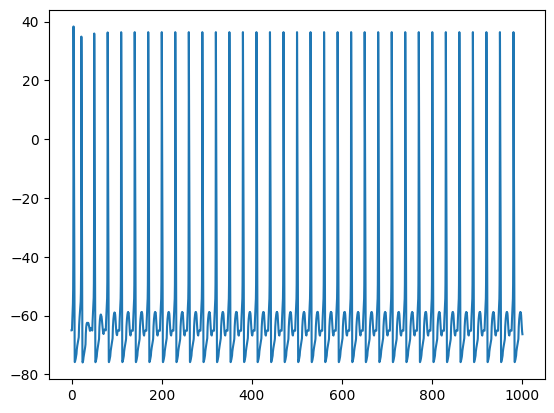

In [14]:
plt.plot(response['soma.v']['time'], response['soma.v']['voltage'])

In [17]:
burst_number_objective.calculate_feature_scores(response)

TypeError: argument of type 'NoneType' is not iterable

## Evaluator

In [ ]:
help(ephys.objectives.EFeatureObjective)

In [ ]:
responses 

In [16]:
burst_number_feature = ephys.efeatures.eFELFeature(
    'burst_number',
    efel_feature_name='burst_number',
    stim_start=0,                                                   
    stim_end=duration,                                                       
)

burst_number_objective = ephys.objectives.SingletonObjective(                    
    burst_number_feature.name,                                                   
    burst_number_feature)               

score_calc = ephys.objectivescalculators.ObjectivesCalculator(               
    [burst_number_objective])

cell_evaluator = ephys.evaluators.CellEvaluator(                             
    cell_model=cell,                                                         
    param_names=['excitatory_expsyn_tau', 'inhibitory_expsyn_tau'],                                              
    fitness_protocols={protocol.name: protocol},                             
    fitness_calculator=score_calc,                                           
    sim=nrn_sim)

In [ ]:
default_param_values = {'excitatory_expsyn_tau': 10.0}                                  

print(cell_evaluator.evaluate_with_dicts(default_param_values))

In [ ]:
default_param_values = {'inhibitory_expsyn_tau': 10.0}                                  

print(cell_evaluator.evaluate_with_dicts(default_param_values))

## optimization

In [ ]:
optimisation = bpopt.optimisations.DEAPOptimisation(                         
    evaluator=cell_evaluator,                                                
    offspring_size=10)                                                       

_, hall_of_fame, _, _ = optimisation.run(max_ngen=5)                         

In [ ]:
best_ind = hall_of_fame[0]                                                   

print('Best individual: ', best_ind)
print('Fitness values: ', best_ind.fitness.values)

best_ind_dict = cell_evaluator.param_dict(best_ind)                          
responses = protocol.run(                                                    
    cell_model=cell,                                                         
    param_values=best_ind_dict,                                              
    sim=nrn_sim)                                                             

time = responses['soma.v']['time']                                           
voltage = responses['soma.v']['voltage']                                     
                                            
plt.style.use('ggplot')                                                      
plt.plot(time, voltage)                                                      
plt.xlabel('Time (ms)')                                                      
plt.ylabel('Voltage (mV)')                                                   
plt.show()        